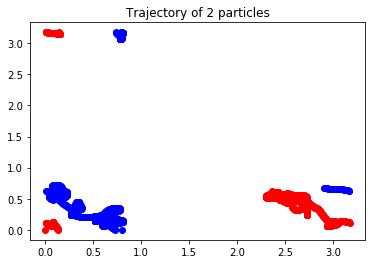

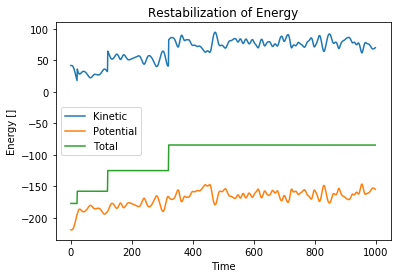

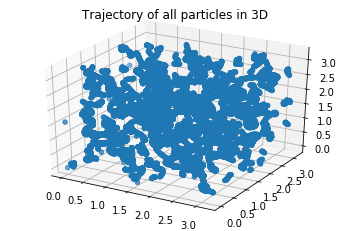

In [523]:
import numpy as np
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation
import scipy.stats as stats
import math

unitCell = np.array([[[0, 0, 0], [0.5, 0.5, 0],
                           [0.5, 0, 0.5], [0, 0.5, 0.5] ]])

eps = 1 #119.8*1.38*10**-23
sigma = 1 #3.405E-10
mass = 1 #6.6E-26

multiplier = 2
D = unitCell.shape[2]
N = multiplier**D*unitCell.shape[1]

rho = 1
L = (N/rho)**(1/D)

dt = 3e-3*np.sqrt(mass*sigma**2/eps)
Timesteps = 1000 #timesteps



def calculateDistance(r):
    N = r.shape[0]
    D = r.shape[1]
        
    bigR = np.broadcast_to(r, (N, N, D))
    bigRT = np.transpose(bigR, (1, 0, 2))
    
    deltaR = bigR - bigRT
    
    # minimal image implementation
    deltaR = (deltaR + L/2)%L - L/2
    
    return deltaR

def calculateForce(r):
    deltaR = calculateDistance(r)
    
    normR = np.linalg.norm(deltaR, axis = 2, keepdims = True)
    mask = np.eye(N, dtype = bool)
    normR[mask,:] = 1
    
    
    deltaU = 4*eps*(6*sigma**6/normR**8 - 12*sigma**12/normR**14)*deltaR
    F = np.sum(deltaU, axis = 1 )
    
    return F


def potentialEnergy(r):
    deltaR = calculateDistance(r)
    normR = np.linalg.norm(deltaR, axis = 2)
    mask = np.eye(N, dtype = bool)

    normR[mask] = 1
    
    U = 4*eps*(sigma**12/normR**12 - sigma**6/normR**6 )
    U[mask] = 0
 
    Utot = 0.5*np.sum(U)
    return Utot

def createLattice(multiplier, unitCell, L):
    latticeStructure = np.ones((multiplier,multiplier,multiplier))
    allUnitCells = np.argwhere(latticeStructure)
    allUnitCells = np.broadcast_to(allUnitCells, (1,multiplier**3,3))
    movingUnitCells = np.swapaxes(allUnitCells, 0, 1) + unitCell
    positions = movingUnitCells.transpose(2,0,1).reshape(3,-1).transpose()
    
    return L/multiplier*positions

def kineticEnergy(v):
    return np.sum(0.5*mass*np.linalg.norm(v)**2)




# initilazing the coordinates and velocities

T_initial = 1
mean = 0
dev = np.sqrt(T_initial)

r = np.zeros((N, D, Timesteps))
r[:,:,0] = createLattice(2, unitCell, L)
v = np.random.normal(mean, dev, (N,D))

F = calculateForce(r[:,:,0])

# initilazing the Energies
kineticE = np.zeros(Timesteps)
potentialE = np.zeros(Timesteps)
kineticE[0] = kineticEnergy(v)
potentialE[0] = potentialEnergy(r[:,:,0])


checkTime = np.arange(20,Timesteps, 100)

for i in range(1,Timesteps):
    kineticE[i] = kineticEnergy(v)
    potentialE[i] = potentialEnergy(r[:,:,i-1])
    #r[:,:,i], v = eulerMethod(r[:,:,i-1] , v)
    
    
    
    Temperature = kineticE[i]/(N-1)*2/3
    
    # verlet algorithm
    r[:,:,i] = r[:,:,i-1] + dt*v + 0.5*calculateForce(r[:,:,i-1])*dt**2
    r[:,:,i] = r[:,:,i]%L   
    
    
    if i in checkTime:
        if (T_initial- Temperature) > 0.01:
            v = np.sqrt(((N-1)*3*Temperature)/kineticE[i])*v
        else:
            v = v + 0.5*dt*(calculateForce(r[:,:,i])+ calculateForce(r[:,:,i-1]))
    else:
        v = v + 0.5*dt*(calculateForce(r[:,:,i])+ calculateForce(r[:,:,i-1]))    
                       

 
################################################################################################
################################# Plots #########################################################    
plt.plot(r[0,0,:], r[0,1,:], 'ro')
plt.plot(r[2,0,:], r[2,1,:], 'bo')
plt.title("Trajectory of 2 particles")



plt.figure()
plt.plot(np.arange(Timesteps), kineticE, label = "Kinetic" )
plt.plot(np.arange(Timesteps), potentialE, label = "Potential")
plt.plot(np.arange(Timesteps), potentialE + kineticE, label =  "Total")

plt.ylabel("Energy []")
plt.xlabel("Time")
plt.title("Restabilization of Energy")
plt.legend()
plt.savefig("Restabilization.png")


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(r[:,0,:], r[:,1,:], r[:,2,:], zdir='z')
plt.title("Trajectory of all particles in 3D")
plt.savefig('Trajectory_of_all_particles in 3D.png')




3.1748021039363987
3.1748021039363987


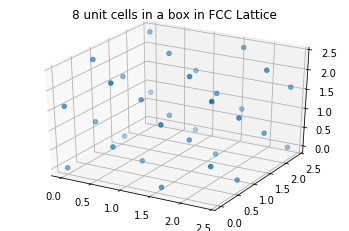

In [501]:
print(L)

conventionalUnitCellMirrorv3 = np.array([[0, 0, 0], [L/2, L/2, 0],
                           [L/2, 0, L/2], [0, L/2, L/2] ])


unitCell = np.array([[[0, 0, 0], [0.5, 0.5, 0],
                           [0.5, 0, 0.5], [0, 0.5, 0.5] ]])

def lattice(multiplier, unitCell, L):
    latticeStructure = np.ones((multiplier,multiplier,multiplier))
    allUnitCells = np.argwhere(latticeStructure)
    allUnitCells = np.broadcast_to(allUnitCells, (1,multiplier**3,3))
    movingUnitCells = np.swapaxes(allUnitCells, 0, 1) + unitCell
    positions = movingUnitCells.transpose(2,0,1).reshape(3,-1).transpose()
    
    return L/multiplier*positions

lattice = lattice(2, unitCell, L)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(lattice[:,0], lattice[:,1], lattice[:,2], zdir='z')
plt.title("8 unit cells in a box in FCC Lattice")
plt.savefig("FCC_lattice.png")


#print(lattice.shape)

print(L)

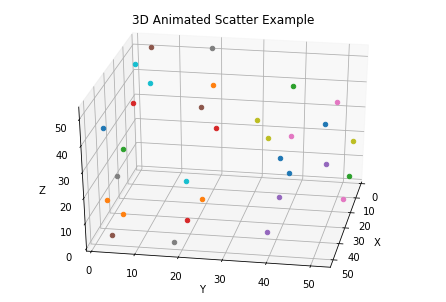

In [401]:
def animate_scatters(iteration, data, scatters):
    """
    Update the data held by the scatter plot and therefore animates it.
    Args:
        iteration (int): Current iteration of the animation
        data (list): List of the data positions at each iteration.
        scatters (list): List of all the scatters (One per element)
    Returns:
        list: List of scatters (One per element) with new coordinates
    """
    for i in range(data[0].shape[0]):
        scatters[i]._offsets3d = (data[iteration][i,0:1], data[iteration][i,1:2], data[iteration][i,2:])
    return scatters

def main(data, save=True):
    """
    Creates the 3D figure and animates it with the input data.
    Args:
        data (list): List of the data positions at each iteration.
        save (bool): Whether to save the recording of the animation. (Default to False).
    """

    # Attaching 3D axis to the figure
    fig = plt.figure()
    ax = p3.Axes3D(fig)

    # Initialize scatters
    scatters = [ ax.scatter(data[0][i,0:1], data[0][i,1:2], data[0][i,2:]) for i in range(data[0].shape[0]) ]

    # Number of iterations
    iterations = Timesteps

    # Setting the axes properties
    ax.set_xlim3d([0, L])
    ax.set_xlabel('X')

    ax.set_ylim3d([0, L])
    ax.set_ylabel('Y')

    ax.set_zlim3d([0, L])
    ax.set_zlabel('Z')

    ax.set_title('3D Animated Scatter Example')

    # Provide starting angle for the view.
    ax.view_init(30, 10)

    ani = animation.FuncAnimation(fig, animate_scatters, iterations, fargs=(data, scatters),
                                       interval=50, blit=True, repeat=True)

    if save:
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800, extra_args=['-vcodec', 'libx264'])
        ani.save('3d-Movement_argon_atoms.mp4', writer=writer)

    plt.show()
data = np.transpose(r, (2,0,1))   
main(data, save=True)

In [316]:
dev = 0.5
mean = 0
D = 3
N = 5
def velocityGauss(N, D, dev, mean):
    return np.random.normal(mean, dev, (N,D))

print(velocityGauss(N,D, dev, mean))


[[-0.16802954 -0.04303696  0.85137941]
 [ 0.17628215 -0.02269437 -0.76581541]
 [ 0.31767042  0.50342727  1.32405183]
 [-0.36438074  0.47293516 -0.37163148]
 [-0.24090068  0.91636578  1.22104801]]
